# Introduction

This lab applies different unsupervised matrix decomposition (dimension reduction) methods from the module **sklearn.decomposition** to the Olivetti faces dataset. The Olivetti faces dataset consists of 400 faces of size 64x64 pixels from 40 individuals, each captured with different facial expressions and lighting conditions.

# Dataset Preparation

First, we load and preprocess the Olivetti faces dataset. We center the data to have zero mean, both globally (focus on one feature, centering all samples) and locally (focus on one sample, centering all features). We also define a base function to plot the gallery of faces.

Dataset consists of 400 faces


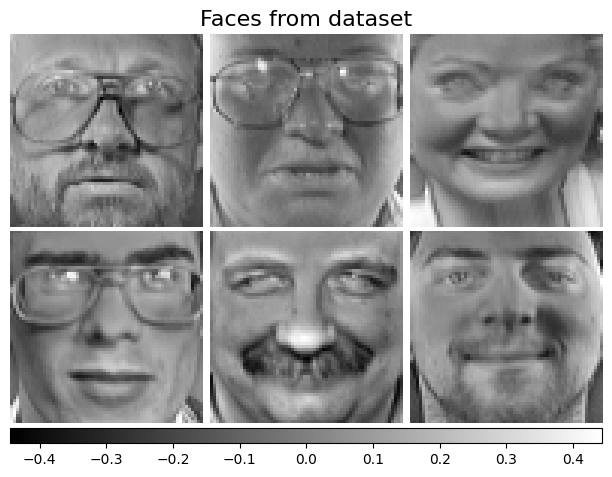

In [1]:
# Loading and preprocessing the Olivetti faces dataset.

import logging

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn import cluster
from sklearn import decomposition

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

# Define a base function to plot the gallery of faces.

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()


# Let's take a look at our data. Gray color indicates negative values,
# white indicates positive values.

plot_gallery("Faces from dataset", faces_centered[:n_components])

# Eigenfaces - PCA using randomized SVD

The first method we apply is PCA, which is a linear dimensionality reduction technique that uses Singular Value Decomposition (SVD) of the data to project it to a lower dimensional space. We use randomized SVD, which is a faster approximation of the standard SVD algorithm. We plot the first six principal components, which are called eigenfaces.

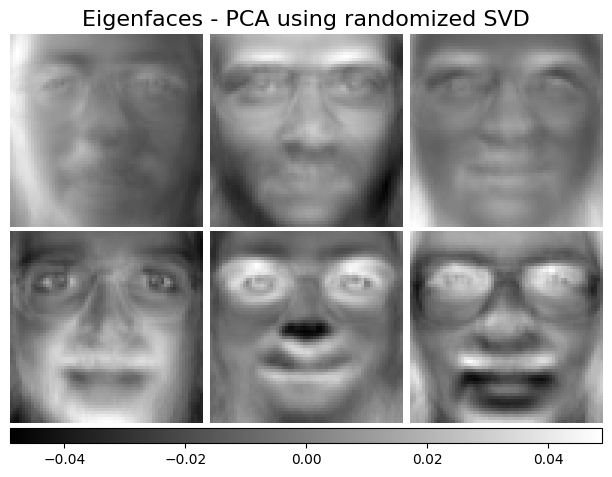

In [2]:
# Eigenfaces - PCA using randomized SVD
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

# Non-negative components - NMF

Next, we apply Non-negative Matrix Factorization (NMF), which factorizes the data matrix into two non-negative matrices, one containing the basis vectors and the other containing the coefficients. This results in a parts-based representation of the data.

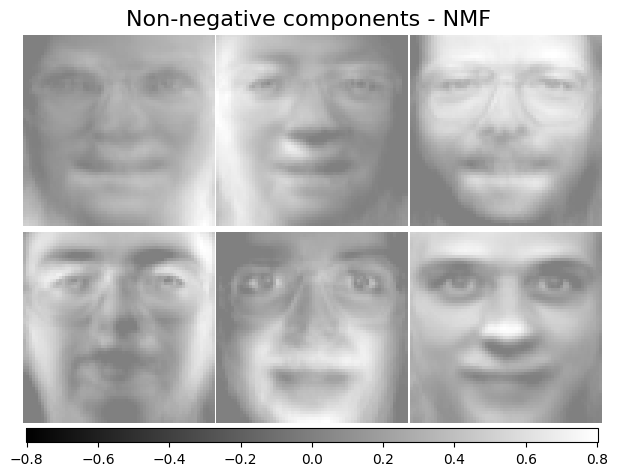

In [3]:
# Non-negative components - NMF
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

# Independent components - FastICA

Independent Component Analysis (ICA) is a method for separating multivariate signals into additive subcomponents that are maximally independent. We apply FastICA, which is a fast and robust algorithm for ICA.

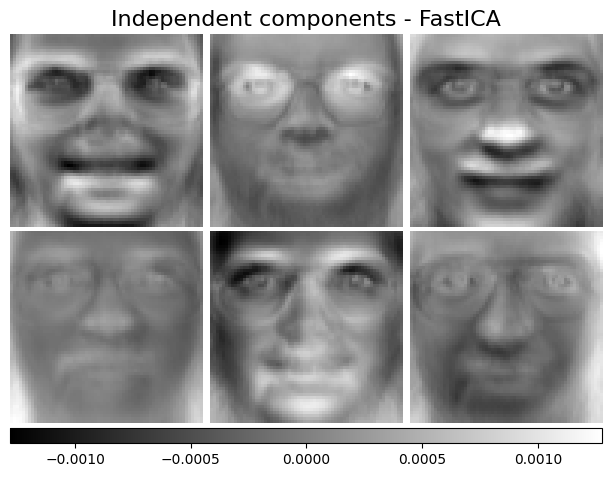

In [4]:
# Independent components - FastICA
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

# Sparse components - MiniBatchSparsePCA

Sparse PCA is a variant of PCA that encourages sparsity in the loading vectors, resulting in a more interpretable decomposition. We use MiniBatchSparsePCA, which is a faster version of SparsePCA that is better suited for large datasets.

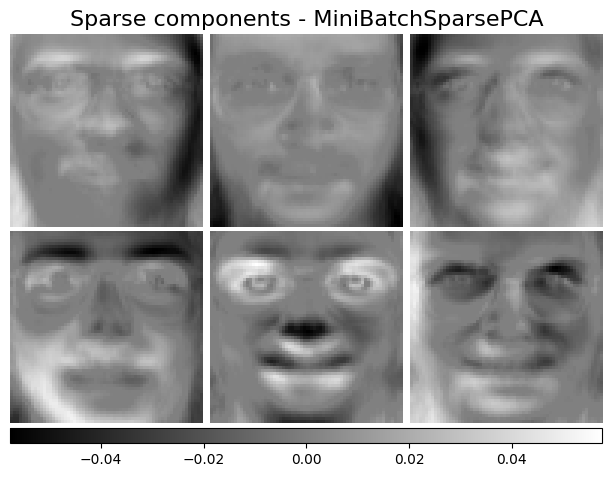

In [5]:
# Sparse components - MiniBatchSparsePCA
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, max_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

# Dictionary learning

Dictionary learning is a method for finding a sparse representation of the input data as a combination of simple elements, which form a dictionary. We apply MiniBatchDictionaryLearning, which is a faster version of DictionaryLearning that is better suited for large datasets.

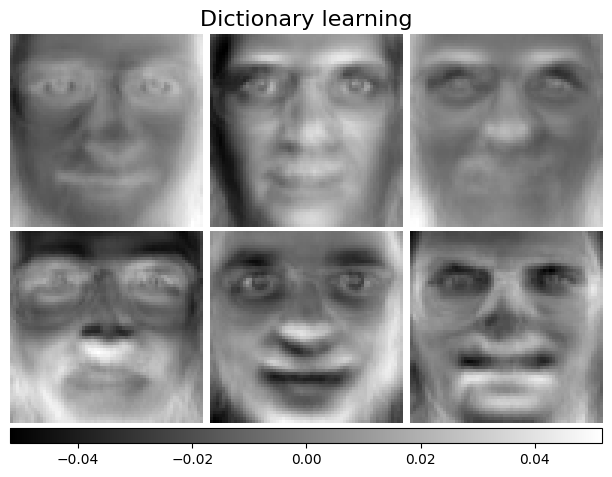

In [6]:
# Dictionary learning
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

# Cluster centers - MiniBatchKMeans

K-means clustering is a method for partitioning a dataset into clusters by minimizing the sum of squared distances between each point and the centroid of its assigned cluster. We apply MiniBatchKMeans, which is a faster version of KMeans that is better suited for large datasets.

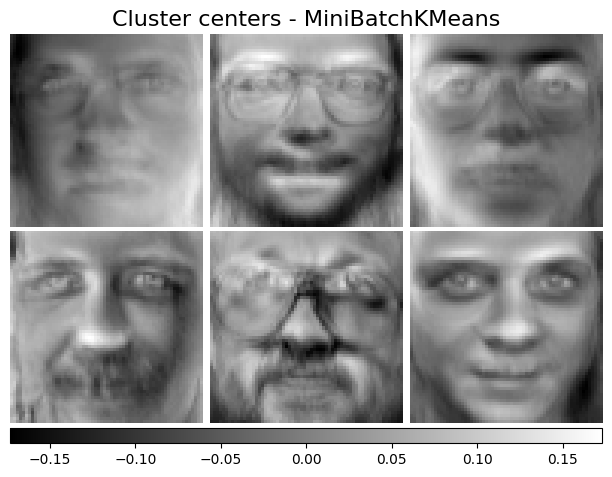

In [7]:
# Cluster centers - MiniBatchKMeans
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
    n_init="auto",
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

# Factor Analysis components - FA

Factor Analysis is a method for modeling the variance in every direction of the input space independently (heteroscedastic noise), similar to PCA but with this advantage. We apply FactorAnalysis, which is an implementation of Factor Analysis in scikit-learn.

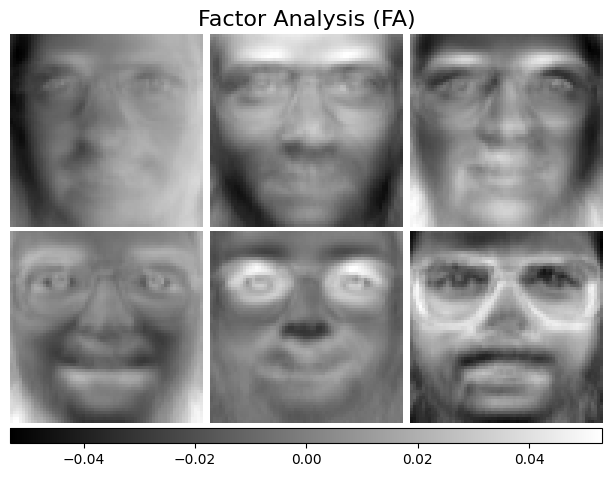

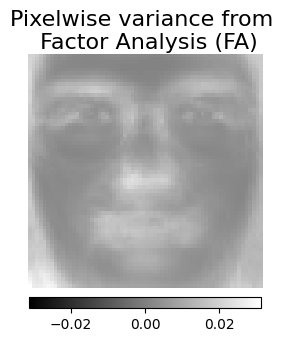

In [8]:
# Factor Analysis components - FA
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

# Decomposition: Dictionary learning

We apply MiniBatchDictionaryLearning again, but this time we enforce positivity when finding the dictionary and/or coding coefficients.

# Dictionary learning - positive dictionary

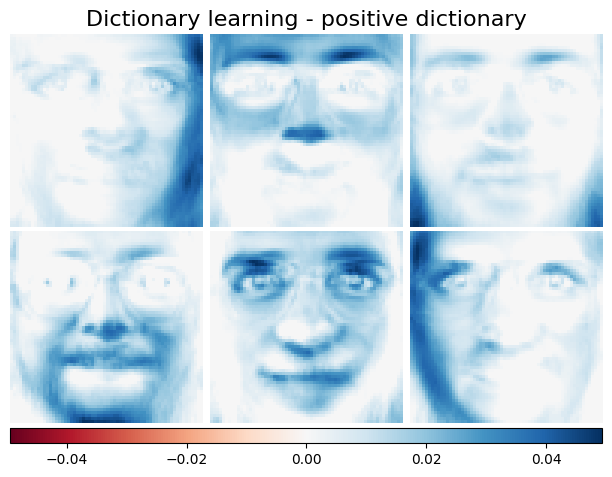

In [9]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Dictionary learning - positive code

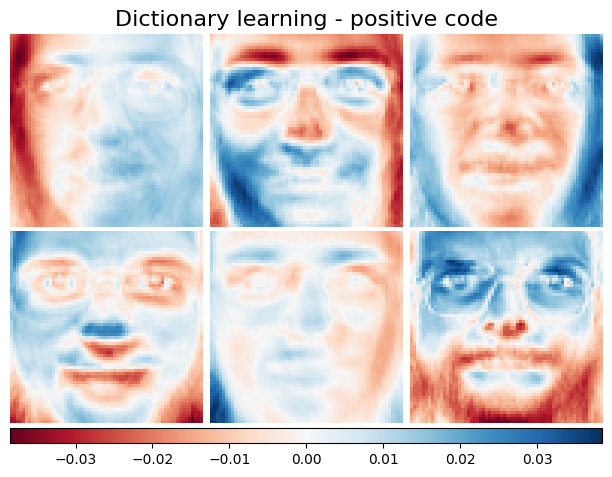

In [10]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Dictionary learning - positive dictionary & code

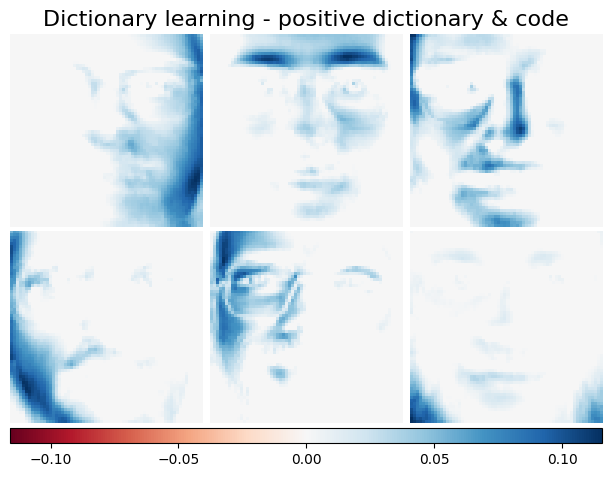

In [11]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Summary

In this lab, we applied various unsupervised matrix decomposition methods to the Olivetti faces dataset. We used PCA, NMF, ICA, Sparse PCA, Dictionary Learning, K-means clustering, and Factor Analysis to extract different types of features from the data. We also enforced positivity when finding the dictionary and/or coding coefficients in the Dictionary Learning method. Overall, these methods can be useful for reducing the dimensionality of high-dimensional datasets and extracting meaningful features for downstream tasks such as classification and clustering.